In [ ]:
# Install required libraries
!pip install Pillow scikit-learn numpy torch torchvision tqdm

# 1. Download Tiny ImageNet (approx. 120,000 images, 200 classes)
print("Downloading Tiny ImageNet dataset...")
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip -O tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip
print("Download and extraction complete.")

# 2. Imports
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
import json
from tqdm.notebook import tqdm

--2026-01-05 20:53:19--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2026-01-05 20:53:19--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  17.7MB/s    in 15s     

2026-01-05 20:53:35 (16.2 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

Download and extraction complete.


In [ ]:
# --- Configuration ---
# Use ResNet-50 for feature extraction.
# Set a low batch size to be safe, but a larger one speeds up processing if GPU memory allows (e.g., 256 or 512).
BATCH_SIZE = 256
# We extract features from the training set, which is the corpus of 100,000 images.
DATA_ROOT = './tiny-imagenet-200/train'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Image Transformations
# Images must be resized to 224x224 for ResNet and normalized using ImageNet stats.
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 2. Dataset and DataLoader
# We use the ImageFolder structure since Tiny ImageNet is organized by class folders.
train_dataset = datasets.ImageFolder(DATA_ROOT, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"Total images in corpus: {len(train_dataset)}")

# 3. Load Pre-trained ResNet-50
# We want the features, so we remove the final classification layer (fc).
model = models.resnet50(pretrained=True)
model = nn.Sequential(*(list(model.children())[:-1])) # Remove the last layer (average pool and FC)
model.to(DEVICE)
model.eval()
print("ResNet-50 model loaded and set up for feature extraction.")

Total images in corpus: 100000


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


ResNet-50 model loaded and set up for feature extraction.


In [ ]:
all_embeddings = []
all_filenames = []

print("Starting feature extraction (Estimated 30-60 minutes on T4 GPU)...")

with torch.no_grad():
    for images, labels in tqdm(train_loader, desc="Extracting Features"):
        images = images.to(DEVICE)

        # Forward pass: returns a tensor of shape [BATCH_SIZE, 2048, 1, 1] for ResNet-50
        output = model(images)

        # Flatten the features: [BATCH_SIZE, 2048]
        embeddings = output.squeeze().cpu().numpy()
        all_embeddings.append(embeddings)

# Concatenate all batches into a single NumPy array
feature_embeddings = np.concatenate(all_embeddings, axis=0)

# Check the final shape (should be [100000, 2048])
print(f"\nFeature extraction complete. Total shape: {feature_embeddings.shape}")

Starting feature extraction (Estimated 30-60 minutes on T4 GPU)...


Extracting Features:   0%|          | 0/391 [00:00<?, ?it/s]


Feature extraction complete. Total shape: (100000, 2048)


In [ ]:
# --- Configuration ---
# Target dimension for PCA
PCA_COMPONENTS = 256

print(f"Starting PCA to reduce dimension from 2048 to {PCA_COMPONENTS}...")

# 1. Initialize PCA
pca_model = PCA(n_components=PCA_COMPONENTS)

# 2. Fit and transform the embeddings
embeddings_for_clustering = pca_model.fit_transform(feature_embeddings)

print(f"PCA complete. Final embedding shape: {embeddings_for_clustering.shape}")

# Optional: Check explained variance (should be high, e.g., > 90%)
explained_variance = np.sum(pca_model.explained_variance_ratio_)
print(f"Cumulative Explained Variance by {PCA_COMPONENTS} components: {explained_variance:.4f}")

Starting PCA to reduce dimension from 2048 to 256...
PCA complete. Final embedding shape: (100000, 256)
Cumulative Explained Variance by 256 components: 0.9216


In [ ]:
# *isko nahi chalana*
# # --- Configuration ---
# # We choose K=500 for finer-grained retrieval (2.5x the number of ground-truth classes)
# NUM_CLUSTERS = 500
# # Set a random state for reproducibility
# RANDOM_STATE = 42
# #
# print(f"Starting K-Means clustering with K={NUM_CLUSTERS} (Estimated 10-20 minutes)...")

# # 1. Initialize K-Means
# kmeans = KMeans(
#     n_clusters=NUM_CLUSTERS,
#     init='k-means++',
#     max_iter=300,
#     n_init=10,
#     random_state=RANDOM_STATE,
#     verbose=0,
#     tol=1e-4,
#     algorithm='lloyd' # 'lloyd' is the standard algorithm
# )

# # 2. Fit the model to the embeddings
# kmeans.fit(embeddings_for_clustering)

# print("K-Means clustering complete.")




SyntaxError: invalid syntax (ipython-input-711158285.py, line 1)

In [ ]:
# # *isko toh galti se bhi nahi chalana*

# print("\n--- Clustering Evaluation ---")

# # 1. Calculate Silhouette Score
# # Warning: Calculating this on 100,000 samples is very memory/time intensive.
# # We sample a subset for a representative estimate.
# SAMPLE_SIZE = 10000
# sample_indices = np.random.choice(len(embeddings_for_clustering), size=SAMPLE_SIZE, replace=False)
# sample_embeddings = embeddings_for_clustering[sample_indices]
# sample_labels = kmeans.labels_[sample_indices]

# # Ensure the sample contains more than one cluster label
# unique_labels = np.unique(sample_labels)
# if len(unique_labels) > 1:
#     print("Calculating Silhouette Score (on sample)...")
#     silhouette_avg = silhouette_score(sample_embeddings, sample_labels)
#     print(f"Silhouette Score (K={NUM_CLUSTERS}): {silhouette_avg:.4f}")
# else:
#     print("Sample size too small to calculate Silhouette Score; clusters may be too large or uniform.")


# # 2. Calculate Davies-Bouldin Index (Lower is better)
# # Note: This is also computationally expensive.
# print("Calculating Davies-Bouldin Index (on sample)...")
# db_index = davies_bouldin_score(sample_embeddings, sample_labels)
# print(f"Davies-Bouldin Index (K={NUM_CLUSTERS}): {db_index:.4f}")

# # 3. Inertia (Elbow Method Value)
# print(f"Inertia (Sum of Squared Distances): {kmeans.inertia_:.2f}")

# # 4. Cluster Size Distribution (A good check for balanced clustering)
# cluster_counts = np.bincount(kmeans.labels_)
# print(f"Min Cluster Size: {np.min(cluster_counts)}")
# print(f"Max Cluster Size: {np.max(cluster_counts)}")
# print(f"Average Cluster Size: {np.mean(cluster_counts):.2f}")


### 4. K-Value Selection (Elbow Method)

To determine the optimal number of clusters (K), we'll use the Elbow Method. This involves training K-Means with different K values and plotting the inertia (sum of squared distances within clusters) against K. The 'elbow point' in the plot, where the rate of decrease in inertia slows down, typically indicates the optimal K.

For efficiency, this evaluation will be performed on a sampled subset of the embeddings.

In [ ]:
# --- Configuration for Elbow Method ---
# Range of K values to test
k_range = range(100, 800, 100) # From 100 to 1000, step of 100

# Sample a subset of embeddings for faster computation
ELBOW_SAMPLE_SIZE = 10000
np.random.seed(42) # Use the same random state for reproducibility
sample_indices = np.random.choice(len(embeddings_for_clustering), size=ELBOW_SAMPLE_SIZE, replace=False)
sampled_embeddings = embeddings_for_clustering[sample_indices]

# Store inertia values for each K
inertia_values = []

print(f"Starting Elbow Method evaluation on a sample of {ELBOW_SAMPLE_SIZE} embeddings...")

for k in tqdm(k_range, desc="Evaluating K for Elbow Method"):
    kmeans_elbow = KMeans(
        n_clusters=k,
        init='k-means++',
        max_iter=100, # Reduced max_iter for faster sampling
        n_init=3,     # Reduced n_init for faster sampling
        random_state=42,
        verbose=0,
        algorithm='lloyd'
    )
    kmeans_elbow.fit(sampled_embeddings)
    inertia_values.append(kmeans_elbow.inertia_)

print("Elbow Method evaluation complete.")

Starting Elbow Method evaluation on a sample of 10000 embeddings...


Evaluating K for Elbow Method:   0%|          | 0/7 [00:00<?, ?it/s]

Elbow Method evaluation complete.


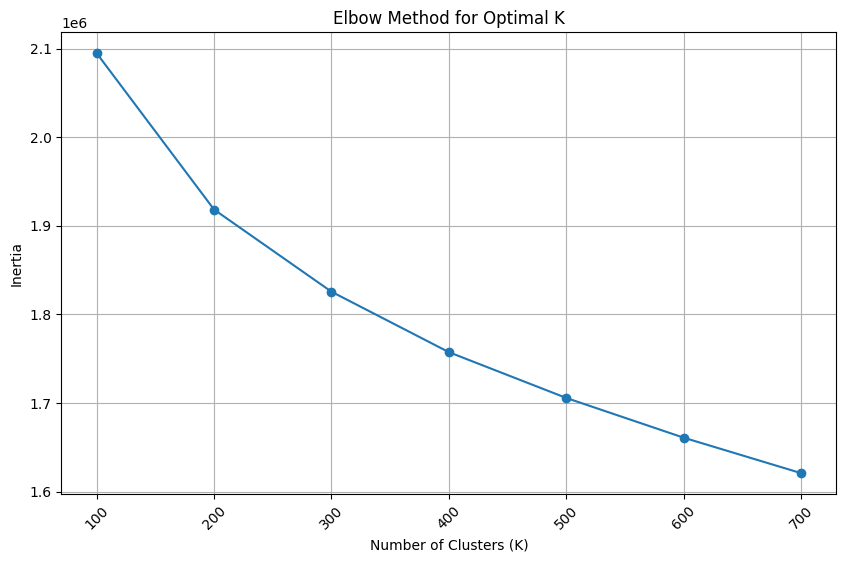

Please examine the plot above to identify the 'elbow point' which suggests the optimal K value.


In [ ]:
import matplotlib.pyplot as plt

# Plot the Elbow Method curve
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(list(k_range), rotation=45)
plt.grid(True)
plt.show()

print("Please examine the plot above to identify the 'elbow point' which suggests the optimal K value.")

plot se value find hgi best K phir usko input krdo ab pore dataset ki embeding pr train hoga toh ye time lega 20 mint plus

### 5. Final K-Means Training

Based on the Elbow Method plot, input your chosen optimal K value below. The K-Means model will then be trained on the **full** dataset with this K.

In [ ]:
# --- Configuration ---
# Input your chosen K value from the Elbow Method plot
OPTIMAL_K = 300 # @param {type:"integer"}

# Set a random state for reproducibility
RANDOM_STATE = 42

print(f"Starting K-Means clustering with optimal K={OPTIMAL_K} on the full dataset...")

# 1. Initialize K-Means with the chosen optimal K
kmeans_final = KMeans(
    n_clusters=OPTIMAL_K,
    init='k-means++',
    max_iter=300,
    n_init=10,
    random_state=RANDOM_STATE,
    verbose=0,
    tol=1e-4,
    algorithm='lloyd' # 'lloyd' is the standard algorithm
)

# 2. Fit the model to the full embeddings
kmeans_final.fit(embeddings_for_clustering)

print("Final K-Means clustering complete.")

Starting K-Means clustering with optimal K=300 on the full dataset...
Final K-Means clustering complete.


In [ ]:
print("\n--- Clustering Evaluation (Final Model) ---")

# 1. Calculate Silhouette Score
# Warning: Calculating this on 100,000 samples is very memory/time intensive.
# We sample a subset for a representative estimate.
SAMPLE_SIZE = 10000
sample_indices = np.random.choice(len(embeddings_for_clustering), size=SAMPLE_SIZE, replace=False)
sample_embeddings = embeddings_for_clustering[sample_indices]
sample_labels = kmeans_final.labels_[sample_indices]

# Ensure the sample contains more than one cluster label
unique_labels = np.unique(sample_labels)
if len(unique_labels) > 1:
    print("Calculating Silhouette Score (on sample)...")
    silhouette_avg = silhouette_score(sample_embeddings, sample_labels)
    print(f"Silhouette Score (K={OPTIMAL_K}): {silhouette_avg:.4f}")
else:
    print("Sample size too small to calculate Silhouette Score; clusters may be too large or uniform.")


# 2. Calculate Davies-Bouldin Index (Lower is better)
# Note: This is also computationally expensive.
print("Calculating Davies-Bouldin Index (on sample)...")
db_index = davies_bouldin_score(sample_embeddings, sample_labels)
print(f"Davies-Bouldin Index (K={OPTIMAL_K}): {db_index:.4f}")

# 3. Inertia (Elbow Method Value)
print(f"Inertia (Sum of Squared Distances): {kmeans_final.inertia_:.2f}")

# 4. Cluster Size Distribution (A good check for balanced clustering)
cluster_counts = np.bincount(kmeans_final.labels_)
print(f"Min Cluster Size: {np.min(cluster_counts)}")
print(f"Max Cluster Size: {np.max(cluster_counts)}")
print(f"Average Cluster Size: {np.mean(cluster_counts):.2f}")


--- Clustering Evaluation (Final Model) ---
Calculating Silhouette Score (on sample)...
Silhouette Score (K=300): 0.0354
Calculating Davies-Bouldin Index (on sample)...
Davies-Bouldin Index (K=300): 2.9346
Inertia (Sum of Squared Distances): 18639628.00
Min Cluster Size: 76
Max Cluster Size: 703
Average Cluster Size: 333.33


In [ ]:
# 1. Save Embeddings (PCA reduced)
np.save('embeddings.npy', embeddings_for_clustering)

# 2. Save K-Means Labels (The cluster ID for each image)
np.save('cluster_labels.npy', kmeans_final.labels_)

# 3. Save Filenames (Save relative paths to preserve structure and extension)
# train_dataset.root is './tiny-imagenet-200/train'
root_path = train_dataset.root
if not root_path.endswith('/'):
    root_path += '/'
# The samples tuple format is (path, class_index)
filenames = [os.path.relpath(f[0], start='./tiny-imagenet-200') for f in train_dataset.samples]

with open('filenames.json', 'w') as f:
    json.dump(filenames, f)

# 4. Save PCA Model
with open('pca_model.pkl', 'wb') as f:
    pickle.dump(pca_model, f)

# 5. Save KMeans Model
with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_final, f)

print("\n--- Artifacts Saved (Final Model) ---")
print("Files created: embeddings.npy, cluster_labels.npy, filenames.json, pca_model.pkl, kmeans_model.pkl")
print("These files contain all the data needed for the Image Retrieval UI and the optional Classifier.")


--- Artifacts Saved (Final Model) ---
Files created: embeddings.npy, cluster_labels.npy, filenames.json, pca_model.pkl, kmeans_model.pkl
These files contain all the data needed for the Image Retrieval UI and the optional Classifier.


In [ ]:
import zipfile
import os

# Define the list of files to be zipped
files_to_zip = [
    'embeddings.npy',
    'cluster_labels.npy',
    'filenames.json',
    'pca_model.pkl',
    'kmeans_model.pkl'
]

zip_filename = 'image_retrieval_artifacts.zip'

print(f"Creating {zip_filename}...")

with zipfile.ZipFile(zip_filename, 'w') as zf:
    for file in files_to_zip:
        if os.path.exists(file):
            zf.write(file, os.path.basename(file))
            print(f"  Added {file} to the zip archive.")
        else:
            print(f"  Warning: {file} not found and will not be added to the zip.")

print(f"\nAll specified artifacts have been successfully zipped into {zip_filename}.")

Creating image_retrieval_artifacts.zip...
  Added embeddings.npy to the zip archive.
  Added cluster_labels.npy to the zip archive.
  Added filenames.json to the zip archive.
  Added pca_model.pkl to the zip archive.
  Added kmeans_model.pkl to the zip archive.

All specified artifacts have been successfully zipped into image_retrieval_artifacts.zip.


# Testing Sections

In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pickle
import json
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files
import zipfile
from scipy.spatial.distance import euclidean

In [ ]:
!unzip -q '/content/image_retrieval_artifacts.zip'

replace embeddings.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


### 6. Image Retrieval Functionality

Now we will set up the functions to perform image retrieval. This involves loading the saved models and creating a pipeline to process a query image and find similar images in the dataset.

In [ ]:
# Load the necessary artifacts
print("Loading saved models and data...")

with open('pca_model.pkl', 'rb') as f:
    loaded_pca_model = pickle.load(f)

with open('kmeans_model.pkl', 'rb') as f:
    loaded_kmeans_model = pickle.load(f)

with open('filenames.json', 'r') as f:
    loaded_filenames = json.load(f)

loaded_cluster_labels = np.load('cluster_labels.npy')
loaded_embeddings = np.load('embeddings.npy') # Add this line to load PCA-reduced embeddings

print("Models and data loaded successfully.")

Loading saved models and data...
Models and data loaded successfully.


In [ ]:
from PIL import Image

# Function to get embeddings for a single query image
def get_query_image_embedding(image_path, model, pca_model, transform, device):
    # Load the image
    img = Image.open(image_path).convert('RGB')

    # Apply transformations
    img_t = transform(img).unsqueeze(0).to(device) # Add batch dimension and move to device

    # Extract features
    model.eval() # Ensure model is in evaluation mode
    with torch.no_grad():
        embedding = model(img_t).squeeze().cpu().numpy()

    # Apply PCA reduction
    pca_embedding = pca_model.transform(embedding.reshape(1, -1))

    return pca_embedding

print("Query image embedding function defined.")

Query image embedding function defined.


In [ ]:
# Function to find similar images
def find_similar_images(query_embedding, kmeans_model, all_cluster_labels, all_filenames, all_embeddings, num_results=10):
    # Predict the cluster for the query image
    query_cluster_id = kmeans_model.predict(query_embedding)[0]

    # Find all images belonging to this cluster
    indices_in_cluster = np.where(all_cluster_labels == query_cluster_id)[0]

    # Calculate distances to all images in the cluster
    distances = []
    for idx in indices_in_cluster:
        img_embedding = all_embeddings[idx]
        dist = euclidean(query_embedding.flatten(), img_embedding.flatten())
        distances.append((dist, idx))

    # Sort by distance (ascending)
    distances.sort(key=lambda x: x[0])

    # Get filenames and distances for the top N results
    similar_image_data = [] # List of (path, distance) tuples
    for dist, idx in distances[:num_results]:
        path = os.path.join('./tiny-imagenet-200', all_filenames[idx])
        similar_image_data.append((path, dist))

    return similar_image_data

print("Similar image retrieval function defined with confidence score.")

Similar image retrieval function defined with confidence score.


In [ ]:
import matplotlib.pyplot as plt

# Function to display images
def display_images(image_data_list, title="Similar Images", cols=5):
    if not image_data_list:
        print("No images to display.")
        return

    # Extract distances from actual similar images (excluding the query image's 0.0 distance if present)
    actual_distances = [item[1] for item in image_data_list if isinstance(item, tuple) and item[1] > 0]
    max_dist = max(actual_distances) if actual_distances else 1.0 # Avoid division by zero if all distances are 0 or no similar images

    rows = (len(image_data_list) + cols - 1) // cols
    plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle(title, fontsize=16)

    for i, item in enumerate(image_data_list):
        plt.subplot(rows, cols, i + 1)
        img_path = None
        score_text = ""
        confidence_text = ""

        if isinstance(item, tuple) and len(item) == 2:
            img_path, dist_score = item
            score_text = f"Dist: {dist_score:.2f}"

            if dist_score == 0.0: # This is likely the query image
                confidence_val = 1.0
            elif max_dist > 0: # Calculate confidence inversely proportional to distance
                confidence_val = 1.0 - (dist_score / max_dist)
            else:
                confidence_val = 1.0 # Fallback if max_dist is zero (e.g., all images are identical)
            confidence_text = f"Conf: {confidence_val:.2f}"

        else: # Fallback for cases where item is just a path (e.g., if query image is passed as just a path)
            img_path = item
            score_text = "Query"
            confidence_text = "Conf: 1.00"

        try:
            img = Image.open(img_path)
            plt.imshow(img)
            # Combine filename, distance, and confidence in title
            plt.title(f"{os.path.basename(img_path).split('_')[0]}\n({score_text}, {confidence_text})")
            plt.axis('off')
        except FileNotFoundError:
            print(f"Warning: Image not found at {img_path}")
            plt.title(f"Image Not Found\n({score_text}, {confidence_text})")
            plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print("Image display function defined with score and confidence display.")

Image display function defined with score and confidence display.


### Test Image Retrieval

Now, let's test the retrieval system. You can either upload a local image or use one of the images from the Tiny ImageNet dataset for demonstration.

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Device: cpu


Saving cat.jpg to cat.jpg
Uploaded image: cat.jpg

Processing query image: cat.jpg


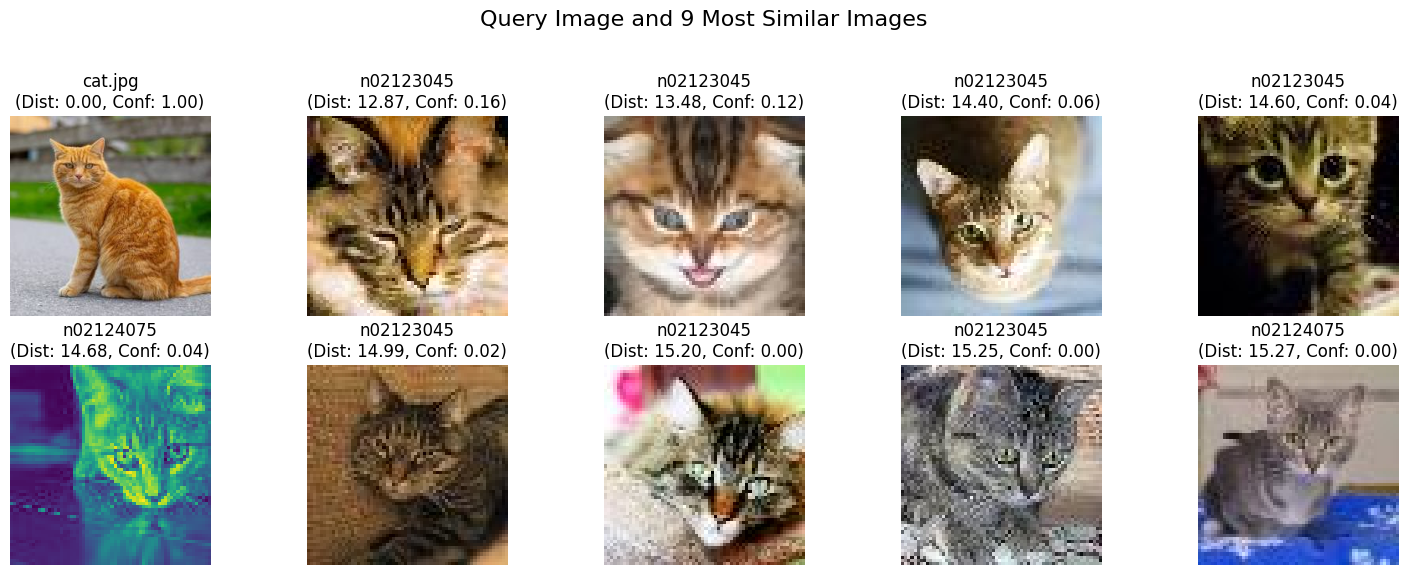

In [ ]:
from google.colab import files

# --- Re-initialize essential variables for image retrieval ---
# This is added to ensure 'model', 'transform', and 'DEVICE' are defined
# in case the kernel restarted or previous cells were not executed.
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE = "cpu"
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load Pre-trained ResNet-50
model = models.resnet50(pretrained=True)
model = nn.Sequential(*(list(model.children())[:-1])) # Remove the last layer
model.to(DEVICE)
print(f"Device: {DEVICE}")
model.eval() # Set model to evaluation mode
# --- End of re-initialization ---

# @markdown --- Choose an option for the query image: ---
QUERY_IMAGE_OPTION = 'Upload an image' # @param ['Upload an image', 'Use an image from the dataset']
DATASET_IMAGE_INDEX = 1000 # @param {type:"integer", min:0, max:99999}

query_image_path = None

if QUERY_IMAGE_OPTION == 'Upload an image':
    uploaded = files.upload()
    if uploaded:
        query_image_path = list(uploaded.keys())[0]
        print(f"Uploaded image: {query_image_path}")
    else:
        print("No image uploaded. Please upload an image to proceed.")
elif QUERY_IMAGE_OPTION == 'Use an image from the dataset': # Changed from else to elif to be explicit
    # Get a random image path from the dataset for demonstration
    if 0 <= DATASET_IMAGE_INDEX < len(loaded_filenames):
        query_image_path = os.path.join('./tiny-imagenet-200', loaded_filenames[DATASET_IMAGE_INDEX])
        print(f"Using dataset image (index {DATASET_IMAGE_INDEX}): {query_image_path}")
    else:
        print(f"Invalid dataset image index. Please choose an index between 0 and {len(loaded_filenames) - 1}.")

if query_image_path:
    print(f"\nProcessing query image: {query_image_path}")

    # 1. Get query image embedding
    query_embedding_pca = get_query_image_embedding(
        query_image_path, model, loaded_pca_model, transform, DEVICE
    )

    # 2. Find similar images
    # Display the query image first, then 9 similar images
    num_retrieval_results = 9 # Total images to display, excluding the query image

    # Updated call to find_similar_images to include loaded_embeddings and get scores
    similar_images_with_scores = find_similar_images(
        query_embedding_pca, loaded_kmeans_model, loaded_cluster_labels, loaded_filenames, loaded_embeddings, num_retrieval_results
    )

    # Prepend the query image path to the list for display (query image score is 0.0 or can be omitted)
    display_list = [(query_image_path, 0.0)] + similar_images_with_scores

    # 3. Display results
    display_images(display_list, title="Query Image and 9 Most Similar Images", cols=5)
else:
    print("Cannot proceed with image retrieval without a query image.")